# ***Living Coasts*** Information and Training <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


## Mapping conversions and modifications of land cover

**Land Cover** is the physical and biological cover of the land surface and includes vegetation (managed or semi-natural), water and bare surfaces.  The land cover maps generated through Living Land Management use the legends of the United Nation's Food and Agriculture Organisation (FAO) Land Cover Classification System (LCCS).

Transitions between any two Level 3 land cover types (off-diagonals in a transition matrix) correspond to a change in extent in both the original class at the time of the first observation (T1) and the replacement class in the second observation (T2) (i.e., a land cover **conversion**). More detailed descriptions of the land cover class prior to and following the change can be provided by referencing the categorical and continuous environmental descriptors used in the construction of the FAO LCCS classes at T1 and T2 respectively as well as AEDs. 

Where the Level 3 class remains the same between time-separated periods (the on-diagonals in the transition matrix), a modification rather than conversion of the land cover occurs and only changes in the amounts or type of state indictors within the Level 3 class can take place. These changes can only be described by considering variations (decreases, increases or no difference) in what are termed Essential Environmental Descriptors (EEDs) that are required to construct the FAO LCCS or Additional Environmental Descriptors (AEDs) that are not required but provide additional descriptors.  These descriptors can be units of measurements (or categorizations of these; e.g. canopy cover in %) or simply a change in a pre-defined category (e.g., representing lifeform or leaf type).

The notebooks take you through the process of accessing the FAO LCCS layer at Level 3 (Basic; 6 classes) and Level 4 (over 100 classes) and comparing these over time to map conversions and modifications.

1. Loading and displaying DEA land cover classifications (basic and detailed) and contributing environmental descriptors for an area of interest.
2. Determing areas of land cover conversions (losses and gains) based on time-series comparison of the land cover maps between two years.
3. Determining areas of no change in the FAO LCCS Level 3 classes where there is potential for a modification to occur. 
4. Comparing the lifeform category of the FAO LCCS Level 3 to indicate one form of modification (changes or otherwise in woody or herbaceous lifeforms).

This notebook requires a basic understanding of the DEA Land Cover data set. 
If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 



## Description 

For a selected area of interest, the notebook compares land cover data for any two years and generates maps of conversions (changes in extent) or modifications (no changes in extent but a change in type (e.g. lifeform) or condition of land covers).   

For demonstration, the capabiliy of the Digital Earth Australia (DEA) processing witin the framework of the Open Data Cube (ODC) is used.  Through Geoscience Australia's (GA) Digital Earth Australia (DEA) Land Cover, land cover maps have been generated for 34 years (1988 to 2020) from environmental descriptors retreived or classified entirely from Landsat sensor data and according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (Version 2).  The spatial resolution of the mapping is 25 m 
(see DEA Land Cover) at https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat)

The notebooks take you through the process of accessing the FAO LCCS layer at Level 3 (Basic; 6 classes) and Level 4 (over 100 classes). 

1. Loading land cover classifications (basic and detailed) for an area of interest.
2. Plotting a change map using Level 3 data. 
3. Plotting a change map (representing impacts) based on evidence gathered from Level 4 data.
4. Determining a pressure (in this case, bushfires) from Landsat sensor data.
5. Combining the impacts and pressures to generate a classification according to the notation 'impact (pressure)

This notebook requires a basic understanding of the DEA Land Cover data set. 
If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

## Getting started

To run this analysis, run all the cells in the notebook starting with the 'Load packages and connect to the datacube' cell.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pandas as pd
import xarray as xr
import odc.geo.xr
#import rasterio
import geopandas as gpd # Added from WDC

from odc.algo import xr_reproject # From https://docs.dea.ga.gov.au/notebooks/How_to_guides/Reprojecting_data.html

import sys, os
sys.path.insert(1, os.path.abspath('../Tools'))
from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import wofs_fuser  # Added from DEA plotting
from dea_tools.plotting import rgb, plot_wo  # Added from DEA plotting
from matplotlib import colors as mcolours
from dea_tools.landcover import plot_land_cover, lc_colourmap, make_colorbar
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils import masking # Added from DEA plotting
from datacube.utils.masking import mask_invalid_data
#from datacube.utils import cog  # Temporarily disabled
from datacube.utils.cog import write_cog
# from display_tools import map_geom, rgb # from WDC - not accessing
from ipyleaflet import GeoData # Added from WDC 
from time import time as time # Added from burn notebook
import datetime as dt # Added from burn notebook
from odc.geo.geom import Geometry
from dea_tools.plotting import rgb

from matplotlib.colors import ListedColormap # Added from WDC
import matplotlib.colors as colors # Added from WDC
from matplotlib import colormaps
import matplotlib.pyplot as plt # Added from WDC
from matplotlib.patches import Patch # Added from WDC

from time import time as time # Added from WDC
import warnings # Added from WDC
warnings.filterwarnings("ignore") # Added from WDC

sys.path.append("../Living_Coasts_training")
from landcover import plot_land_cover, lc_colourmap, make_colorbar #added from DEA

#For DEA burn mapping
from datetime import datetime
from datetime import timedelta

from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

from ipyleaflet import DrawControl, FullScreenControl, LayersControl, Map, Rectangle, WidgetControl, basemaps # Added rectangle RML
from ipywidgets import Button, Dropdown, FloatText, GridspecLayout, Layout, HBox, VBox, Output, Tab, interact, widgets

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33973,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:41043,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/46149/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:38489,


### Load packages

Load key Python packages and supporting functions for the analysis, then connect to the datacube. 

### Connect to the datacube
Connect to the datacube so we can access DEA data. 

In [2]:
dc = datacube.Datacube(app="Land_cover_change_mapping")

## Select and view your study area

**If running the notebook for the first time,** keep the default settings below.
This will demonstrate how the change mapping functionality works and provide meaningful results.
The following example loads land cover data over Mount Ney in Western Australia, a region which has experienced extensive bushfires and variations in water inundation over the 34 years of observation.  

**NOTE:  You can change the area of interest and also the time range in subsequent user-selected runs of the notebook.

In [3]:
# Additional libraries etc.

from datacube.utils.geometry import Geometry, CRS
from ipyleaflet import GeoData
from display_tools import map_geom, rgb

sys.path.append("../Tools/wdc_tools")
from wdc_datahandling import geopolygon_masking

In [4]:
# add in vector data for area of interest
#Area = 'uploads/AOIs/Fitzroy-riverbend.geojson'
Area = 'uploads/AOIs/Fitzroy-mangroves.geojson'
#Area = 'uploads/AOIs/Stradbroke-Island-north.json'
Area = gpd.read_file(Area)

In [5]:
display_map(x=(Area.total_bounds[0], Area.total_bounds[2]), y=(Area.total_bounds[1], Area.total_bounds[3]))

In [6]:
# Set the range of dates for the analysis
time_range = ("2009", "2020")

# Loop through polygons in geodataframe and extract satellite data
for index, row in Area.iterrows(): 
    # Extract the feature's geometry as a datacube geometry object (this needs to be updated eventually for Shapely 2.0)
    geom = Geometry(geom=row.geometry, crs=Area.crs)
#    geom = Geometry(geom=Area.iloc[0].geometry, 
#                         crs=CRS("epsg:32755"))    
    # Update the query to include our geopolygon
    query = {'geopolygon': geom,
    "time": time_range,             
        }

In [7]:
# Get colour map for image
cmap, norm = lc_colourmap('level3_change_colour_scheme')

# Define dates and/or period of interest


#### Load and reproject CCI Biomass data

## 3.1  Observed change
The observed change considers conversions (i.e., changes in extent of the Level 3 classes) and modification (i.e., the level 3 class remains the same but there are changes in categorical (e.g., lifeform) or continuous (e.g., water hydroperiod) environmental descriptors.  

#### Numerical key for changes in overarching environmental descriptors
01: CTV greening 				111111 - cover  
02: CTV browning 				111111 - cover  
03: CAV wetting  				123123 - moisture  
04: CAV drying   				123123 - moisture  
05: NTV extent loss 			112 to ALL  
06: NTV extent gain				ALL to 112  
07: NTV herbaceous increase		112112 – cover (non-woody)  
08: NTV herbaceous decrease		112112 – cover (non-woody)  
09: NTV woody increase			112112 – cover and woody fraction  
10: NTV woody decrease			112112 – cover and woody fraction  
11: NAV extent gain				124 to ALL 
12: NAV extent loss				ALL to 124  
13: NAV herbaceous vegetation increase	124124	- cover (non-woody)  
14: NAV herbaceous vegetation decreases	124124	- cover (non-woody)  
15: NAV woody vegetation increase		124124	- cover and woody fraction  
16: NAV woody vegetation decreases		124124	- cover and woody fraction  
17: AS extent gain				ALL to 215  
18: AS extent loss				215 to ALL  
19: NWAW extent gain 			ALL to 220  
20: NWAW extent loss			220 to ALL  
21: NWAW persistence increase	220220 – water persistence  
22: NWAW Persistence decrease	220220 – water persistence
23: Conversion of NTV to NAV
24: Conversion of NAV to NTV
25: Conversion of CTV to CAV
26: Conversion of CAV to CTV
27: NTV loss to urban
28: NAV loss to urban

Note that 27 and 28 avoids the duplication of 112 to 215 in 12 and also in 17.

### Plot the land cover over the time-series (level 3 and lifeform)

## Load and view the Environmental Descriptors (EDs)
The following cell will load what are termed the Environmental Descriptors (EDs) used to construct the Basic (Level 3) and subsequently the Detailed (Level 4) land cover maps for the `lat_range`, `lon_range` and `time_range` defined for your area of interest.

You can view each of these layers using the  `plot_land_cover()` function.

** Note:  You can run one, several or all of these to view the appropriate product.

In [8]:
# Load land cover data for our polygon and time period
#lc_dataset = dc.load(product='lw_landcover_lw', **query)
#lc_dataset_masked = geopolygon_masking(lc_dataset, geopolygon=geom)

# Step 3: Load DEA Land Cover data from the datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:32755",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
    print("Data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")
    
lc_dataset_masked = geopolygon_masking(lc, geopolygon=geom)

Data loaded successfully.


In [9]:
# Section 6: Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)
item_checkbox = widgets.Checkbox(description='Intertidal Elevation', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')
        if item_checkbox.value:
            selected_datasets.append('item')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            elif dataset == 'item':
                plot_land_cover(item.elevation[0])
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
    item_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

Button(description='Plot Selected Data', style=ButtonStyle())

Output()

### Level 3 change maps 

A first step towards developing a globally relevant and standardized taxonomy and framework for consistently describing land cover change was to establish the transition matrix between observed broad land cover classes (i.e., OEDs).  This stage was developed and is illustrated using the FAO LCCS given the dichotomous and then hierarchical modular structure of this taxonomy.  Between-class transitions and within-class changes can be identified by comparing these OEDs (i.e., the FAO LCCS Level 3 classes; 8 in total) between any two time-separated periods (i.e., T1 and T2), leading to 64 potential change categories; 56 on the off-diagonals and 8 on the on-diagonals.  

** Note:  There are 6 classes in the case of Australia as there are limited cultivated aquatic landscapes, and artificial and natural water are merged.

In the following steps, you will compare the earliest and latest Level 3 layers in selected time-series.

#### Select the start and end dates for comparisons of enviromental descriptors 
(e.g., Level 3, lifeform, vegetation cover, water state and level 4 (full classification))

#### ALL LEVEL 3 CHANGES

### GAINS

#### Change (gains) in Level 3 from 2010 [0] to 2020 [4 or -1]

In [10]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)
ignore_no_change = True
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)

In [11]:
level_3 = lc.level3[0].drop_vars("time")

In [12]:
# Create a new Xarray.DataArray
obs_gain_l3_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [13]:
obs_gain_l3 = obs_gain_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_gain_l3_2010_2020

### Plot Level 3 gains

In [14]:
# Get colour map for image
#cmap, norm = lc_colourmap('level3_change_colour_scheme')
cmap, norm = lc_colourmap('level3_change_colour_gain')

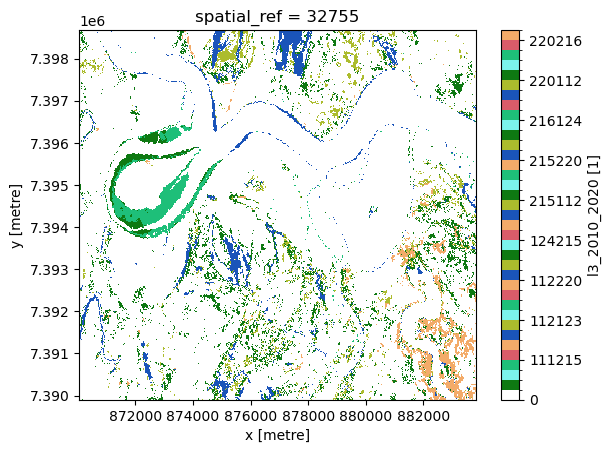

In [15]:
obs_gain_l3.l3_2010_2020.plot(cmap=cmap, norm=norm)

In [16]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_gain_l3["l3_2010_2020"],
          fname='./outputs/obs_gain_l3_2010_2020.tif',
          overwrite=True)

PosixPath('outputs/obs_gain_l3_2010_2020.tif')

### LOSSES

#### Identify change (loss) in Level 3 from 2010 [0] to 2020 [-1 or 4]

In [17]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
# (Note changing to (end * 1000) + start
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
#level_3 = lc.level3[0].drop_vars("time")

In [18]:
# Create a new Xarray.DataArray
obs_loss_l3_2010_2020= xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed losses",
    attrs=level_3.attrs,
    fastpath=False,
)

In [19]:
obs_loss_l3 = obs_loss_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_loss_l3_2010_2020

#### Change from 2017 [1] to 2018 [2]

#### Plot Level 3 losses

In [20]:
# Get colour map for image
#cmap, norm = lc_colourmap('level3_change_colour_scheme')
cmap, norm = lc_colourmap('level3_change_colour_gain')

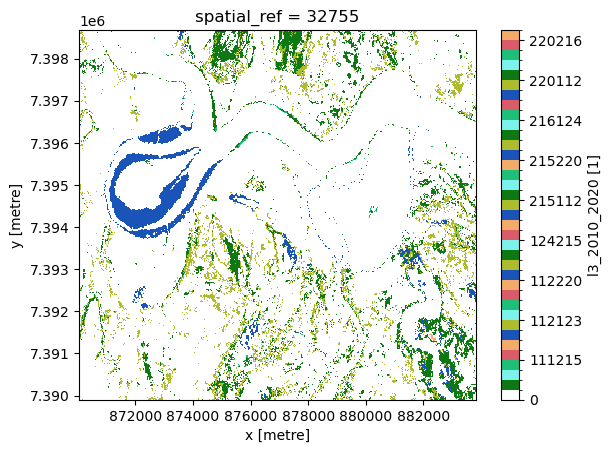

In [21]:
obs_loss_l3.l3_2010_2020.plot(cmap=cmap, norm=norm)

In [22]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_loss_l3["l3_2010_2020"],
          fname='./outputs/obs_loss_l3_2010_2020.tif',
          overwrite=True)

PosixPath('outputs/obs_loss_l3_2010_2020.tif')

### NO CHANGE

#### Areas of no change from 2010 [0] to 2020 [-1 or 4]

In [23]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)

# Mark if you want to ignore no change
ignore_no_change = False

# Combine classifications from start and end dates
change_vals = (start * 1000) + end

# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
    
level_3 = lc.level3[0].drop_vars("time") 

# Create a new Xarray.DataArray
obs_change_l3_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [24]:
obs_change_l3 = obs_change_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_change_l3_2010_2020

In [25]:
# Get colour map for image
#cmap, norm = lc_colourmap('level3_change_colour_scheme')
cmap, norm = lc_colourmap('level3_change_colour_scheme')

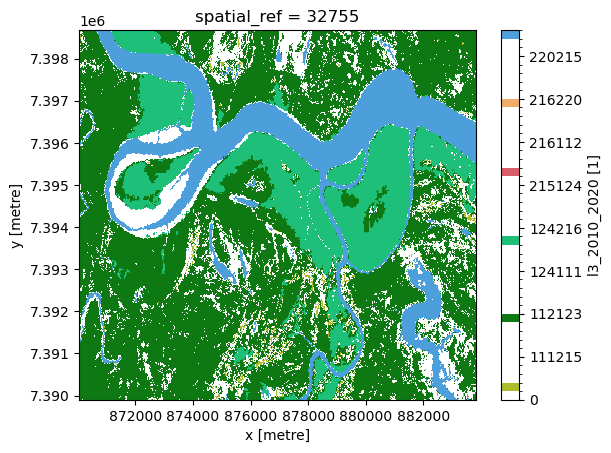

In [26]:
obs_change_l3.l3_2010_2020.plot(cmap=cmap, norm=norm)

In [27]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_change_l3["l3_2010_2020"],
          fname='./outputs/obs_change_l3_2010_2020.tif',
          overwrite=True)

PosixPath('outputs/obs_change_l3_2010_2020.tif')

## Lifeform change maps

#### Change in Lifeform from 2010 [0] to 2020 [4 or -1]

In [28]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[0].astype(np.int32)
end = lc.lifeform[-1].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[0].drop_vars("time")

In [29]:
# Create a new Xarray.DataArray
obs_change_lf_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="lifeform change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [30]:
obs_change_lf = obs_change_lf_2010_2020.to_dataset(name="lf_2010_2020")

#### Plot lifeform change

In [31]:
#make_colorbar(fig, axs[2], measurement='lfchange_colour_scheme')
cmap, norm = lc_colourmap('lfchange_colour_scheme')

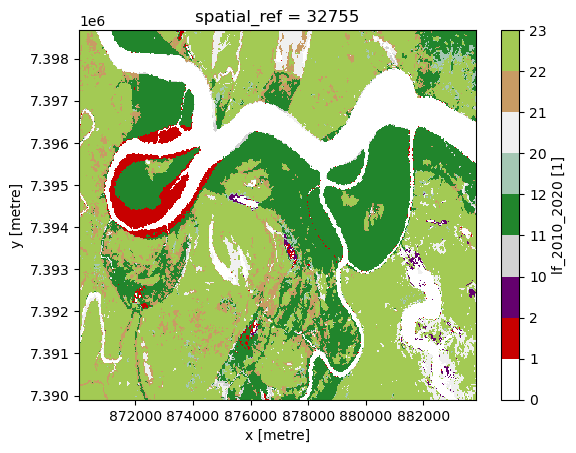

In [32]:
obs_change_lf.lf_2010_2020.plot(cmap=cmap, norm=norm)

In [33]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_change_lf["lf_2010_2020"],
          fname='./outputs/obs_change_lf_2010_2020.tif',
          overwrite=True)

PosixPath('outputs/obs_change_lf_2010_2020.tif')

### Water persistence changes

In [47]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.water_persistence[0].astype(np.int32)
end = lc.water_persistence[-1].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
water_persistence = lc.water_persistence[0].drop_vars("time")

In [48]:
# Create a new Xarray.DataArray
obs_change_wper_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="water persistence change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [49]:
obs_change_wper = obs_change_wper_2010_2020.to_dataset(name="wper_2010_2020")

In [50]:
#make_colorbar(fig, axs[2], measurement='wperchange_colour_scheme')
cmap, norm = lc_colourmap('wperchange_colour_scheme')

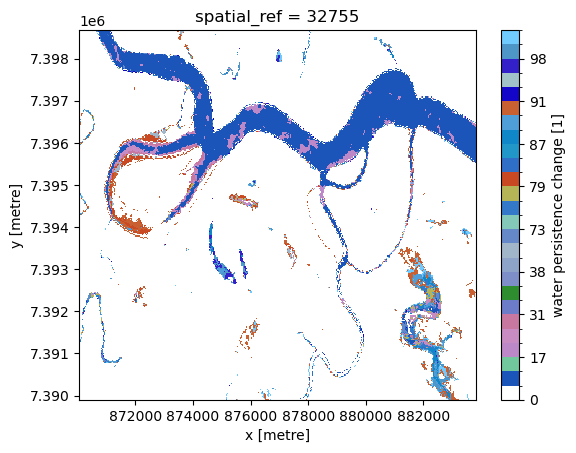

In [51]:
obs_change_wper_2010_2020.plot(cmap=cmap, norm=norm)

### Biomass change

In [52]:
# Step 1: Load above ground biomass datasets (SouthEast Queensland)
AGB2010 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2010_AGBcz.tif"
AGB2015 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2015_AGBcz.tif"
AGB2016 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2016_AGBcz.tif"
AGB2017 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2017_AGBcz.tif"
AGB2018 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2018_AGBcz.tif"
AGB2019 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2019_AGBcz.tif"
AGB2020 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2020_AGBcz.tif"
AGB2021 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2021_AGBcz.tif"
SD2010 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2010_SDcz.tif"
SD2015 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2015_SDcz.tif"
SD2016 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2016_SDcz.tif"
SD2017 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2017_SDcz.tif"
SD2018 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2018_SDcz.tif"
SD2019 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2019_SDcz.tif"
SD2020 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2020_SDcz.tif"
SD2021 = "../Uploads/AGB/S20E150_Qld_SEast/S20E150_2021_SDcz.tif"

# Step 1: Load above ground biomass datasets (South East Western Australia)
#AGB2010 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2010_AGBcz.tif"
#AGB2015 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2015_AGBcz.tif"
#AGB2016 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2016_AGBcz.tif"
#AGB2017 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2017_AGBcz.tif"
#AGB2018 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2018_AGBcz.tif"
#AGB2019 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2019_AGBcz.tif"
#AGB2020 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2020_AGBcz.tif"
#AGB2021 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2021_AGBcz.tif"
#SD2010 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2010_SDcz.tif"
#SD2015 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2015_SDcz.tif"
#SD2016 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2016_SDcz.tif"
#SD2017 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2017_SDcz.tif"
#SD2018 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2018_SDcz.tif"
#SD2019 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2019_SDcz.tif"
#SD2020 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2020_SDcz.tif"
#SD2021 = "../Uploads/AGB/S30E120_WA_SEast/S30E120_2021_SDcz.tif"

# Far North Queensland
#AGB2010 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2010_AGBcz.tif"
#AGB2015 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2015_AGBcz.tif"
#AGB2016 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2016_AGBcz.tif"
#AGB2017 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2017_AGBcz.tif"
#AGB2018 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2018_AGBcz.tif"
#AGB2019 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2019_AGBcz.tif"
#AGB2020 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2020_AGBcz.tif"
#AGB2021 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2021_AGBcz.tif"
#SD2010 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2010_SDcz.tif"
#SD2015 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2015_SDcz.tif"
#SD2016 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2016_SDcz.tif"
#SD2017 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2017_SDcz.tif"
#SD2018 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2018_SDcz.tif"
#SD2019 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2019_SDcz.tif"
#SD2020 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2020_SDcz.tif"
#SD2021 = "../Uploads/AGB/S10E140_Qld_North/S10E140_2021_SDcz.tif"

# Victoria
# AGB2010 = "../Uploads/AGB/S30E140_Victoria/S30E140_2010_AGBcz.tif"
# AGB2015 = "../Uploads/AGB/S30E140_Victoria/S30E140_2015_AGBcz.tif"
# AGB2016 = "../Uploads/AGB/S30E140_Victoria/S30E140_2016_AGBcz.tif"
# AGB2017 = "../Uploads/AGB/S30E140_Victoria/S30E140_2017_AGBcz.tif"
# AGB2018 = "../Uploads/AGB/S30E140_Victoria/S30E140_2018_AGBcz.tif"
# AGB2019 = "../Uploads/AGB/S30E140_Victoria/S30E140_2019_AGBcz.tif"
# AGB2020 = "../Uploads/AGB/S30E140_Victoria/S30E140_2020_AGBcz.tif"
# AGB2021 = "../Uploads/AGB/S30E140_Victoria/S30E140_2021_AGBcz.tif"
# SD2010 = "../Uploads/AGB/S30E140_Victoria/S30E140_2010_SDcz.tif"
# SD2015 = "../Uploads/AGB/S30E140_Victoria/S30E140_2015_SDcz.tif"
# SD2016 = "../Uploads/AGB/S30E140_Victoria/S30E140_2016_SDcz.tif"
#SD2017 = "../Uploads/AGB/S30E140_Victoria/S30E140_2017_SDcz.tif"
#SD2018 = "../Uploads/AGB/S30E140_Victoria/S30E140_2018_SDcz.tif"
#SD2019 = "../Uploads/AGB/S30E140_Victoria/S30E140_2019_SDcz.tif"
#SD2020 = "../Uploads/AGB/S30E140_Victoria/S30E140_2020_SDcz.tif"
#SD2021 = "../Uploads/AGB/S30E140_Victoria/S30E140_2021_SDcz.tif"

# Step 2: Resample to geobox
AGB2010_prj = rio_slurp_xarray(AGB2010,lc.geobox,resampling="nearest")
AGB2015_prj = rio_slurp_xarray(AGB2015,lc.geobox,resampling="nearest")
AGB2016_prj = rio_slurp_xarray(AGB2016,lc.geobox,resampling="nearest")
AGB2017_prj = rio_slurp_xarray(AGB2017,lc.geobox,resampling="nearest")
AGB2018_prj = rio_slurp_xarray(AGB2018,lc.geobox,resampling="nearest")
AGB2019_prj = rio_slurp_xarray(AGB2019,lc.geobox,resampling="nearest")
AGB2020_prj = rio_slurp_xarray(AGB2020,lc.geobox,resampling="nearest")
AGB2021_prj = rio_slurp_xarray(AGB2021,lc.geobox,resampling="nearest")
SD2010_prj = rio_slurp_xarray(SD2010,lc.geobox,resampling="nearest")
SD2015_prj = rio_slurp_xarray(SD2015,lc.geobox,resampling="nearest")
SD2016_prj = rio_slurp_xarray(SD2016,lc.geobox,resampling="nearest")
SD2017_prj = rio_slurp_xarray(SD2017,lc.geobox,resampling="nearest")
SD2018_prj = rio_slurp_xarray(SD2018,lc.geobox,resampling="nearest")
SD2019_prj = rio_slurp_xarray(SD2019,lc.geobox,resampling="nearest")
SD2020_prj = rio_slurp_xarray(SD2020,lc.geobox,resampling="nearest")
SD2021_prj = rio_slurp_xarray(SD2021,lc.geobox,resampling="nearest")

AGB2010_prj = mask_invalid_data(AGB2010_prj)
AGB2015_prj = mask_invalid_data(AGB2015_prj)
AGB2016_prj = mask_invalid_data(AGB2016_prj)
AGB2017_prj = mask_invalid_data(AGB2017_prj)
AGB2018_prj = mask_invalid_data(AGB2018_prj)
AGB2019_prj = mask_invalid_data(AGB2019_prj)
AGB2020_prj = mask_invalid_data(AGB2020_prj)
AGB2021_prj = mask_invalid_data(AGB2021_prj)

AGB2010_prj = AGB2010_prj.where(AGB2010_prj!=0)
AGB2015_prj = AGB2015_prj.where(AGB2015_prj!=0)
AGB2016_prj = AGB2016_prj.where(AGB2016_prj!=0)
AGB2017_prj = AGB2017_prj.where(AGB2017_prj!=0)
AGB2018_prj = AGB2018_prj.where(AGB2018_prj!=0)
AGB2019_prj = AGB2019_prj.where(AGB2019_prj!=0)
AGB2020_prj = AGB2020_prj.where(AGB2020_prj!=0)
AGB2021_prj = AGB2021_prj.where(AGB2021_prj!=0)

SD2010_prj = mask_invalid_data(SD2010_prj)
SD2015_prj = mask_invalid_data(SD2015_prj)
SD2016_prj = mask_invalid_data(SD2016_prj)
SD2017_prj = mask_invalid_data(SD2017_prj)
SD2018_prj = mask_invalid_data(SD2018_prj)
SD2019_prj = mask_invalid_data(SD2019_prj)
SD2020_prj = mask_invalid_data(SD2020_prj)
SD2021_prj = mask_invalid_data(SD2021_prj)

# Step 3: Generate uncertainties based on stock differences
AGB = AGB2010_prj.to_dataset(name="AGB2010")
AGB["AGB2015"] = AGB2017_prj
AGB["AGB2016"] = AGB2018_prj
AGB["AGB2017"] = AGB2017_prj
AGB["AGB2018"] = AGB2018_prj
AGB["AGB2019"] = AGB2019_prj
AGB["AGB2020"] = AGB2020_prj
AGB["AGB2021"] = AGB2021_prj

diff2010_2020=(AGB.AGB2021.fillna(0)-AGB.AGB2010.fillna(0))
diff2010_2015=(AGB.AGB2015.fillna(0)-AGB.AGB2010.fillna(0))
diff2015_2016=(AGB.AGB2016.fillna(0)-AGB.AGB2015.fillna(0))
diff2016_2017=(AGB.AGB2017.fillna(0)-AGB.AGB2016.fillna(0))
diff2017_2018=(AGB.AGB2018.fillna(0)-AGB.AGB2017.fillna(0))
diff2018_2019=(AGB.AGB2019.fillna(0)-AGB.AGB2018.fillna(0))
diff2019_2020=(AGB.AGB2020.fillna(0)-AGB.AGB2019.fillna(0))
diff2020_2021=(AGB.AGB2021.fillna(0)-AGB.AGB2020.fillna(0))
diff2017_2020=(AGB.AGB2021.fillna(0)-AGB.AGB2017.fillna(0))

diff_biomass = diff2010_2020.where(diff2010_2020!=0).to_dataset(name="d2010_2020")
diff_biomass["d2010_2015"] = diff2010_2015.where(diff2010_2015!=0)
diff_biomass["d2015_2016"] = diff2015_2016.where(diff2015_2016!=0)
diff_biomass["d2016_2017"] = diff2016_2017.where(diff2016_2017!=0)
diff_biomass["d2017_2018"] = diff2017_2018.where(diff2017_2018!=0)
diff_biomass["d2018_2019"] = diff2018_2019.where(diff2018_2019!=0)
diff_biomass["d2019_2020"] = diff2019_2020.where(diff2019_2020!=0)
diff_biomass["d2020_2021"] = diff2020_2021.where(diff2020_2021!=0)
diff_biomass["d2017_2020"] = diff2017_2020.where(diff2017_2020!=0)

SD = SD2010_prj.to_dataset(name="SD2010")
SD["SD2015"] = SD2015_prj
SD["SD2016"] = SD2016_prj
SD["SD2017"] = SD2017_prj
SD["SD2018"] = SD2018_prj
SD["SD2019"] = SD2019_prj
SD["SD2020"] = SD2020_prj
SD["SD2021"] = SD2021_prj

del AGB2010, AGB2015, AGB2016, AGB2017, AGB2018, AGB2019, AGB2020, AGB2021, SD2010, SD2015, SD2016, SD2017, SD2018, SD2019, SD2020, SD2021

AGB2010_Min = AGB.AGB2010-SD.SD2010
AGB2010_Max = AGB.AGB2010+SD.SD2010
AGB2015_Min = AGB.AGB2015-SD.SD2015
AGB2015_Max = AGB.AGB2015+SD.SD2015
AGB2016_Min = AGB.AGB2016-SD.SD2016
AGB2016_Max = AGB.AGB2016+SD.SD2016
AGB2017_Min = AGB.AGB2017-SD.SD2017
AGB2017_Max = AGB.AGB2017+SD.SD2017
AGB2018_Min = AGB.AGB2018-SD.SD2018
AGB2018_Max = AGB.AGB2018+SD.SD2018
AGB2019_Min = AGB.AGB2019-SD.SD2019
AGB2019_Max = AGB.AGB2019+SD.SD2019
AGB2020_Min = AGB.AGB2020-SD.SD2020
AGB2020_Max = AGB.AGB2020+SD.SD2020
AGB2021_Min = AGB.AGB2021-SD.SD2021
AGB2021_Max = AGB.AGB2021+SD.SD2021

min_biomass = AGB2010_Min.to_dataset(name="AGB2010_Min")
min_biomass["AGB2015_Min"] = AGB2015_Min
min_biomass["AGB2016_Min"] = AGB2016_Min
min_biomass["AGB2017_Min"] = AGB2017_Min
min_biomass["AGB2018_Min"] = AGB2018_Min
min_biomass["AGB2019_Min"] = AGB2019_Min
min_biomass["AGB2020_Min"] = AGB2020_Min
min_biomass["AGB2021_Min"] = AGB2021_Min

del AGB2010_Min, AGB2015_Min, AGB2016_Min, AGB2017_Min, AGB2018_Min, AGB2019_Min, AGB2020_Min,  AGB2021_Min

max_biomass = AGB2010_Max.to_dataset(name="AGB2010_Max")
max_biomass["AGB2015_Max"] = AGB2015_Max
max_biomass["AGB2016_Max"] = AGB2016_Max
max_biomass["AGB2017_Max"] = AGB2017_Max
max_biomass["AGB2018_Max"] = AGB2018_Max
max_biomass["AGB2019_Max"] = AGB2019_Max
max_biomass["AGB2020_Max"] = AGB2020_Max
max_biomass["AGB2021_Max"] = AGB2021_Max

del AGB2010_Max, AGB2015_Max, AGB2016_Max, AGB2017_Max, AGB2018_Max, AGB2019_Max, AGB2020_Max, AGB2021_Max

cond_dec_2010_2020 = min_biomass.AGB2010_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)
cond_dec_2010_2015 = min_biomass.AGB2010_Min.fillna(0) > max_biomass.AGB2015_Max.fillna(0)
cond_dec_2015_2016 = min_biomass.AGB2015_Min.fillna(0) > max_biomass.AGB2016_Max.fillna(0)
cond_dec_2016_2017 = min_biomass.AGB2016_Min.fillna(0) > max_biomass.AGB2017_Max.fillna(0)
cond_dec_2017_2018 = min_biomass.AGB2017_Min.fillna(0) > max_biomass.AGB2018_Max.fillna(0)
cond_dec_2018_2019 = min_biomass.AGB2018_Min.fillna(0) > max_biomass.AGB2019_Max.fillna(0)
cond_dec_2019_2020 = min_biomass.AGB2019_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)
cond_dec_2020_2021 = min_biomass.AGB2020_Min.fillna(0) > max_biomass.AGB2021_Max.fillna(0)
cond_dec_2017_2020 = min_biomass.AGB2015_Min.fillna(0) > max_biomass.AGB2020_Max.fillna(0)

cond_inc_2010_2020 = max_biomass.AGB2010_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)
cond_inc_2010_2015 = max_biomass.AGB2010_Max.fillna(0) < min_biomass.AGB2015_Min.fillna(0)
cond_inc_2015_2016 = max_biomass.AGB2015_Max.fillna(0) < min_biomass.AGB2016_Min.fillna(0)
cond_inc_2016_2017 = max_biomass.AGB2016_Max.fillna(0) < min_biomass.AGB2017_Min.fillna(0)
cond_inc_2017_2018 = max_biomass.AGB2017_Max.fillna(0) < min_biomass.AGB2018_Min.fillna(0)
cond_inc_2018_2019 = max_biomass.AGB2018_Max.fillna(0) < min_biomass.AGB2019_Min.fillna(0)
cond_inc_2019_2020 = max_biomass.AGB2019_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)
cond_inc_2020_2021 = max_biomass.AGB2020_Max.fillna(0) < min_biomass.AGB2021_Min.fillna(0)
cond_inc_2017_2020 = max_biomass.AGB2015_Max.fillna(0) < min_biomass.AGB2020_Min.fillna(0)

agb_scd = cond_dec_2010_2020.to_dataset(name="cond_dec_2010_2020") 
agb_scd["cond_dec_2010_2015"] = cond_dec_2010_2015
agb_scd["cond_dec_2015_2016"] = cond_dec_2015_2016
agb_scd["cond_dec_2016_2017"] = cond_dec_2016_2017
agb_scd["cond_dec_2017_2018"] = cond_dec_2017_2018
agb_scd["cond_dec_2018_2019"] = cond_dec_2018_2019 
agb_scd["cond_dec_2019_2020"] = cond_dec_2019_2020 
agb_scd["cond_dec_2020_2021"] = cond_dec_2020_2021 
agb_scd["cond_dec_2017_2020"] = cond_dec_2017_2020 

agb_sci = cond_inc_2010_2020.to_dataset(name="cond_inc_2010_2020") 
agb_sci["cond_inc_2010_2015"] = cond_inc_2010_2015
agb_sci["cond_inc_2015_2016"] = cond_inc_2015_2016
agb_sci["cond_inc_2016_2017"] = cond_inc_2016_2017
agb_sci["cond_inc_2017_2018"] = cond_inc_2017_2018
agb_sci["cond_inc_2018_2019"] = cond_inc_2018_2019 
agb_sci["cond_inc_2019_2020"] = cond_inc_2019_2020 
agb_sci["cond_inc_2020_2021"] = cond_inc_2020_2021 
agb_sci["cond_inc_2017_2020"] = cond_inc_2017_2020 

## The Global Change Taxonomy and Evidence-Based Change Framework

This notebooks introduces a globally relevant and standardized taxonomy and framework for consistently describing land cover change based on evidence is presented, which makes use of structured land cover taxonomies and is underpinned by the Driver-Pressure-State-Impact-Response (DPSIR) framework.  

The Global Change Taxonomy currently lists 248 classes based on the notation ‘impact (pressure)’, with this encompassing the consequence of observed change and associated reason(s), and uses scale-independent terms that factor in time. 

Evidence for different impacts is gathered through temporal comparison (e.g., days, decades apart) of land cover classes constructed and described from Environmental Descriptors (EDs; state indicators) with pre-defined measurement units (e.g., m, %) or categories (e.g., species type).  
 

## Evidence for impacts
There are 77 impact categories and each of these can be assigned a unique number (i.e., 1-77).  In this notebook, we will be considering a range of impacts affecting vegetation namely:/
61: Vegetation dieback
62: Vegetation damage


## Impact No. 741: Water depth (decrease)

In [53]:
# Make a mask of 1 for the 'impact' class No. 71 'water depth (decrease)' 
Im71_2010_2020 = np.where(
    (
        ((obs_change_l3.l3_2010_2020 == 220220) & (obs_change_wper.wper_2010_2020 == 17))
        | ((obs_change_l3.l3_2010_2020 == 220220) & (obs_change_wper.wper_2010_2020 == 18))
        | ((obs_change_l3.l3_2010_2020 == 220220) & (obs_change_wper.wper_2010_2020 == 19))
        | ((obs_change_l3.l3_2010_2020 == 220220) & (obs_change_wper.wper_2010_2020 == 78))
        | ((obs_change_l3.l3_2010_2020 == 220220) & (obs_change_wper.wper_2010_2020 == 79))
        | ((obs_change_l3.l3_2010_2020 == 220220) & (obs_change_wper.wper_2010_2020 == 89))
    ),
    1,
    0,
)

Im71_2010_2020xa = xr.DataArray(
    data=Im71_2010_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="71: water depth (decrease)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im71_2010_2020xa = Im71_2010_2020xa

In [54]:
Im71 = Im71_2010_2020xa.to_dataset(name="Im71_2010_2020")

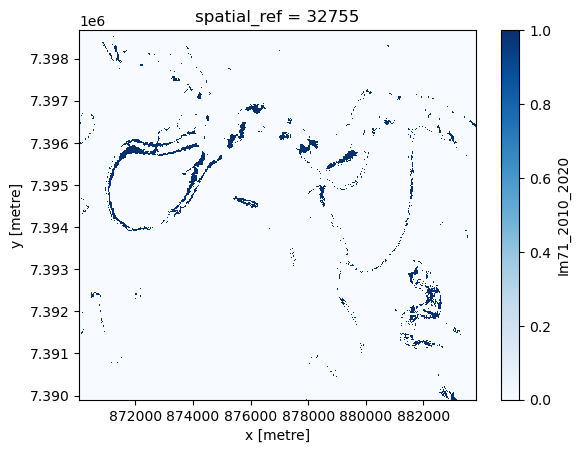

In [55]:
Im71.Im71_2010_2020.plot(cmap='Blues')

## Impact No. 74: Vegetation gain (extent)
Changes in the extent of water indicates a conversion of land cover.

In [56]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im74_2010_2020 = np.where(
    (
        ((obs_change_l3.l3_2010_2020 == 220111))
        | ((obs_change_l3.l3_2010_2020 == 220112))
        | ((obs_change_l3.l3_2010_2020 == 220124))
        | ((obs_change_l3.l3_2010_2020 == 220215))
        | ((obs_change_l3.l3_2010_2020 == 220216))
    ),
    1,
    0,
)

Im74_2010_2020xa = xr.DataArray(
    data=Im74_2010_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="74: water loss (extent)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im74_2010_2020xa = Im74_2010_2020xa

In [57]:
Im74 = Im74_2010_2020xa.to_dataset(name="Im74_2010_2020")

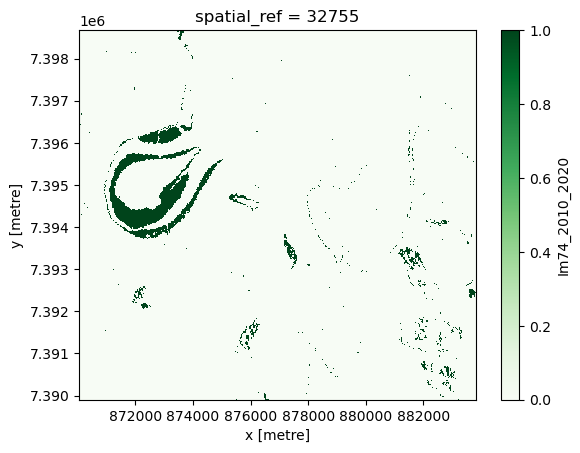

In [58]:
Im74.Im74_2010_2020.plot(cmap='Greens')

### Generate summary maps of impacts

In [59]:
Impact_Comp_2010_2020 = (Im71_2010_2020xa).to_dataset(name="Im71")
Impact_Comp_2010_2020 ["Im74"] = Im74_2010_2020xa
Impact_Comp_2010_2020 ["Sum"] = ((Im71_2010_2020xa*71) + (Im74_2010_2020xa*74))

In [60]:
cmap = ListedColormap(["white", "darkviolet", "blue", "green"])
norm = colors.BoundaryNorm([0, 1, 71, 74], 3)

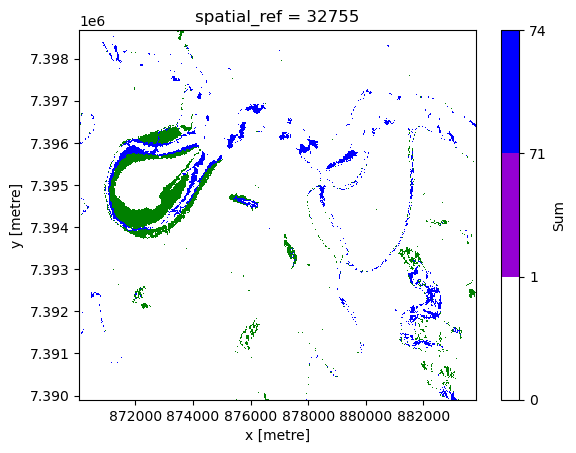

In [61]:
Impact_Comp_2010_2020.Sum.plot(cmap=cmap, norm=norm)

In [62]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=Impact_Comp_2010_2020["Sum"],
          fname='./outputs/impact-summary.tif',
          overwrite=True)

PosixPath('outputs/impact-summary.tif')

## Try out a few more impacts - 



## Impact No. 61: Vegetation dieback

In [68]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im61_2010_2020 = np.where(
    (
        ((obs_change_l3.l3_2010_2020 == 111111) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112112) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 123123) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 124124) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
    ),
    1,
    0,
)
Im61_2010_2020xa = xr.DataArray(
    data=Im61_2010_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="61: vegetation dieback",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im61_2010_2020xa = Im61_2010_2020xa

In [69]:
Im61 = Im61_2010_2020xa.to_dataset(name="Im61_2010_2020")
#del Im45_2010_2020, Im45_2017_2018xa, Im45_2018_2019xa, Im45_2019_2020xa, Im45_2017_2020xa

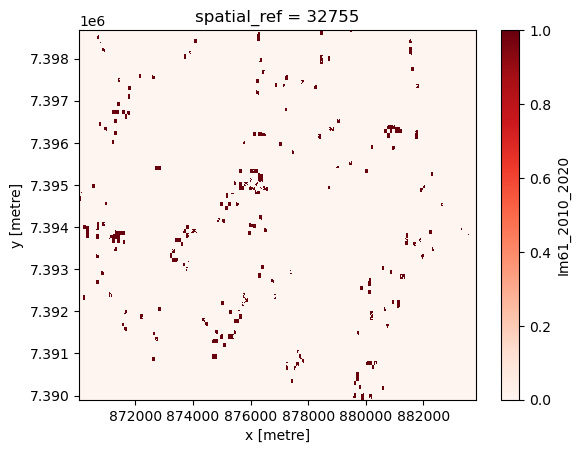

In [70]:
Im61.Im61_2010_2020.plot(cmap='Reds')

## Impact No. 62: Vegetation damage

In [71]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im62_2010_2020 = np.where(
    (
        ((obs_change_l3.l3_2010_2020 == 111111) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112112) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 123123) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 124124) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
    ),
    1,
    0,
)

Im62_2010_2020xa = xr.DataArray(
    data=Im62_2010_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="62: vegetation damage",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 62 'vegetation damage' 
Im62_2010_2020xa = Im62_2010_2020xa

In [72]:
Im62 = Im62_2010_2020xa.to_dataset(name="Im62_2010_2020")

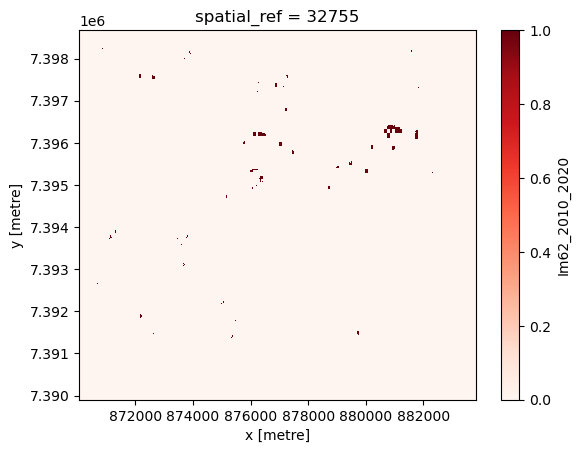

In [74]:
Im62.Im62_2010_2020.plot(cmap='Reds')

## Impact No. 63: Vegetation amount (gain)
Changes in the extent of vegetation are generally a conversion (e.g., natural or semi-natural terrestrial vegetation to or from cultivated/managed vegetation may take place). Here, the change observed is from one land cover to another.

In [75]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im63_2010_2020 = np.where(
    (
        ((obs_change_l3.l3_2010_2020 == 111111) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 > 0) & (agb_sci.cond_inc_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112112) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 > 0) & (agb_sci.cond_inc_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 123123) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 > 0) & (agb_sci.cond_inc_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 124124) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 > 0) & (agb_sci.cond_inc_2010_2020 == 1))
    ),
    1,
    0,
)

Im63_2010_2020xa = xr.DataArray(
    data=Im63_2010_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="46: vegetation amount (gain)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im63_2010_2020xa = Im63_2010_2020xa

In [76]:
Im63 = Im63_2010_2020xa.to_dataset(name="Im63_2010_2020")
#del Im46_2010_2020, Im46_2017_2018xa, Im46_2018_2019xa, Im46_2019_2020xa, Im46_2017_2020xa

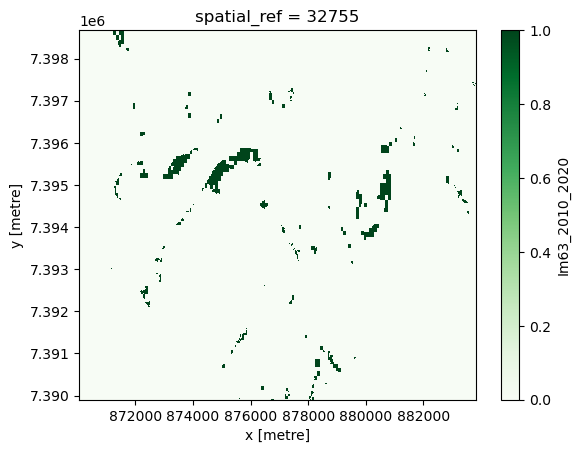

In [77]:
Im63.Im63_2010_2020.plot(cmap='Greens')

## Impact No. 67: Vegetation loss (extent)
Changes in the extent of vegetation is generally a conversion (e.g., natural or semi-natural terrestrial vegetation to or from cultivated/managed vegetation may take place). Here, the change observed is from one land cover to another.

In [82]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im67_2010_2020 = np.where(
    (
        ((obs_change_l3.l3_2010_2020 == 112111) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112215) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112216) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112220) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
    ),
    1,
    0,
)
Im67_2010_2020xa = xr.DataArray(
    data=Im67_2010_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="67: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im67_2010_2020xa = Im67_2010_2020xa

In [83]:
Im67 = Im67_2010_2020xa.to_dataset(name="Im67_2010_2020")
#del Im45_2010_2020, Im45_2017_2018xa, Im45_2018_2019xa, Im45_2019_2020xa, Im45_2017_2020xa

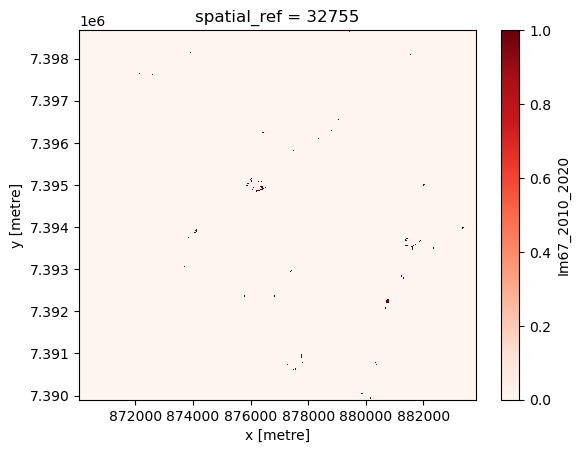

In [84]:
Im67.Im67_2010_2020.plot(cmap='Reds')

## Impact No. 68: Vegetation reduction (amount)
Changes in the amount of vegetation is associated with a modification (noting though that conversions (e.g., natural or semi-natural terrestrial vegetation to or from cultivated/managed vegetation may take place) and results in a change generally in continous variables such as biomass, canopy cover and/or height (among others).  Here, we assume that the land cover has stayed the same.

In [85]:
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im68_2010_2020 = np.where(
    (
        ((obs_change_l3.l3_2010_2020 == 111111) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 112112) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 123123) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
        | ((obs_change_l3.l3_2010_2020 == 124124) & (obs_change_lf.lf_2010_2020 == 11) & (diff_biomass.d2010_2020 < 0) & (agb_scd.cond_dec_2010_2020 == 1))
    ),
    1,
    0,
)

Im68_2010_2020xa = xr.DataArray(
    data=Im68_2010_2020,
    coords=diff_biomass.coords,
    dims=diff_biomass.dims,
    name="68: vegetation amount (loss)",
    attrs=None,
)
# Make a mask of 1 for the 'impact' class No. 44 'vegetation amount (loss)' 
Im68_2010_2020xa = Im68_2010_2020xa

In [86]:
Im68 = Im68_2010_2020xa.to_dataset(name="Im68_2010_2020")

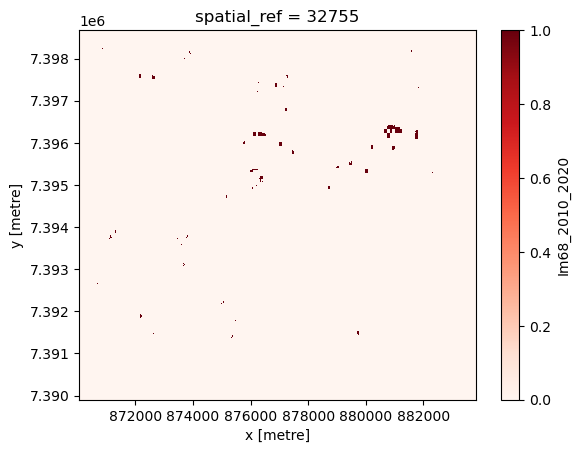

In [87]:
Im68.Im68_2010_2020.plot(cmap='Reds')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2022

**Compatible datacube version:** 

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)